In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [6]:
# Load facilities data
facilities_df = pd.read_csv('facilities_with_risk_scores.csv')
facilities_df = facilities_df.drop('min_distance', axis=1)

# Display the first few rows
print(facilities_df.head())
print(f"Facilities data shape: {facilities_df.shape}")


                       name          type   latitude  longitude  risk_score
0              CVS Pharmacy      pharmacy  27.948538 -82.458507    0.124613
1  Miami Lakes Fire Station  fire_station  25.924045 -80.308954    0.261804
2                  7-Eleven          fuel  27.981761 -82.452878    0.165240
3              CVS Pharmacy      pharmacy  28.546148 -81.204455    0.085822
4                 Walgreens      pharmacy  28.547299 -81.204692    0.085514
Facilities data shape: (3946, 5)


In [7]:
# Load SVI data
svi_df = pd.read_csv('SVI_2022_US_county.csv', dtype={'FIPS': str})

# Ensure FIPS codes have leading zeros
svi_df['FIPS'] = svi_df['FIPS'].str.zfill(5)

# Display the first few rows
print(svi_df.head())
print(f"SVI data shape: {svi_df.shape}")


   ST    STATE ST_ABBR  STCNTY          COUNTY   FIPS  \
0   1  Alabama      AL    1001  Autauga County  01001   
1   1  Alabama      AL    1003  Baldwin County  01003   
2   1  Alabama      AL    1005  Barbour County  01005   
3   1  Alabama      AL    1007     Bibb County  01007   
4   1  Alabama      AL    1009   Blount County  01009   

                  LOCATION    AREA_SQMI  E_TOTPOP  M_TOTPOP  ...  EP_ASIAN  \
0  Autauga County, Alabama   594.454786     58761         0  ...       1.1   
1  Baldwin County, Alabama  1589.861817    233420         0  ...       0.9   
2  Barbour County, Alabama   885.007619     24877         0  ...       0.5   
3     Bibb County, Alabama   622.469286     22251         0  ...       0.3   
4   Blount County, Alabama   644.890376     59077         0  ...       0.2   

   MP_ASIAN  EP_AIAN  MP_AIAN  EP_NHPI  MP_NHPI  EP_TWOMORE  MP_TWOMORE  \
0       0.4      0.1      0.1      0.0      0.1         3.3         1.0   
1       0.1      0.2      0.1      0.0

In [11]:
# Load county GeoJSON data
counties_gdf = gpd.read_file('USA_Counties_(Generalized).geojson')

# Display the first few rows
print(counties_gdf.head())
print(f"Counties GeoDataFrame shape: {counties_gdf.shape}")


   FID  OBJECTID            NAME    STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  \
0    1         1  Aleutians East        Alaska         02       013  02013   
1    2      1201          Traill  North Dakota         38       097  38097   
2    3      1202           Walsh  North Dakota         38       099  38099   
3    4         2  Aleutians West        Alaska         02       016  02016   
4    5      1203            Ward  North Dakota         38       101  38101   

   POPULATION  POP_SQMI  POP2010  ...  AVE_SIZE12  CROP_ACR12  AVE_SALE12  \
0        3129       0.4     3141  ...         -99         -99         -99   
1        8154       9.5     8121  ...        1170      526183      659887   
2       11037       8.5    11119  ...         834      714525      440783   
3        5609       1.6     5561  ...         -99         -99         -99   
4       75147      36.6    61675  ...        1117      829363      285596   

      SQMI  Shape_Leng  Shape_Area   Shape__Area  Shape__Length  \
0

In [12]:
# Load coastline shapefile
coastline_gdf = gpd.read_file('/Users/prachiheda/Desktop/Florida_Shoreline_(1_to_2%2C000%2C000_Scale)/Florida_Shoreline_(1_to_2%2C000%2C000_Scale).shp')  # Replace with actual path

# Ensure the coastline GeoDataFrame is not empty
print(f"Coastline GeoDataFrame shape: {coastline_gdf.shape}")


Coastline GeoDataFrame shape: (15538, 3)


In [13]:
# Load hurricane data
hurricane_data = pd.read_csv('HURDAT2_hurricane_data_with_events.csv')

# Ensure hurricane data has 'latitude', 'longitude', and 'storm_name' columns
print(hurricane_data.head())
print(f"Hurricane data shape: {hurricane_data.shape}")


   storm_id storm_name      date  time record_id event_label status  latitude  \
0  AL011851    UNNAMED  18510625     0       NaN         NaN     HU      28.0   
1  AL011851    UNNAMED  18510625   600       NaN         NaN     HU      28.0   
2  AL011851    UNNAMED  18510625  1200       NaN         NaN     HU      28.0   
3  AL011851    UNNAMED  18510625  1800       NaN         NaN     HU      28.1   
4  AL011851    UNNAMED  18510625  2100         L    Landfall     HU      28.2   

   longitude  max_wind  min_pressure  
0      -94.8        80          -999  
1      -95.4        80          -999  
2      -96.0        80          -999  
3      -96.5        80          -999  
4      -96.8        80          -999  
Hurricane data shape: (54749, 11)


In [14]:
# Merge SVI data with counties GeoDataFrame
counties_gdf['FIPS'] = counties_gdf['FIPS'].astype(str)
merged_gdf = counties_gdf.merge(svi_df[['FIPS', 'RPL_THEMES']], on='FIPS', how='left')

# Filter for Florida counties
florida_gdf = merged_gdf[merged_gdf['STATE_NAME'] == 'Florida'].copy()

# Check for missing SVI data in Florida counties
missing_svi_counties = florida_gdf['RPL_THEMES'].isnull().sum()
print(f"Number of Florida counties without SVI data: {missing_svi_counties}")


Number of Florida counties without SVI data: 0


In [15]:
florida_gdf.head()

,FID,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POPULATION,POP_SQMI,POP2010,...,CROP_ACR12,AVE_SALE12,SQMI,Shape_Leng,Shape_Area,Shape__Area,Shape__Length,GlobalID,geometry,RPL_THEMES
73,74,1270,Alachua,Florida,12,001,12001,262216,270.6,247336,...,58746,60865,968.91,2.085381,0.235556,3.359711e+09,247835.349156,218349dc-b28e-450f-a12d-3c53f4caf175,"POLYGON ((-82.40526 29.4851, -82.55477 29.481,...",0.6099
74,75,1271,Baker,Florida,12,003,12003,28042,47.6,27115,...,4402,41490,588.87,1.683327,0.144074,2.068476e+09,202625.217942,ecb84e6a-4bd9-4562-8926-db1d1a63d467,"POLYGON ((-82.04629 30.13971, -82.14505 30.140...",0.6188
75,76,1272,Bay,Florida,12,005,12005,180035,233.6,168852,...,2689,23632,770.83,3.572319,0.179150,2.570885e+09,425422.855258,a96cca6e-b7fd-415d-8300-2f82166e7637,"MULTIPOLYGON (((-85.38475 30.5741, -85.3821 30...",0.7407
76,77,1273,Bradford,Florida,12,007,12007,26996,89.9,28520,...,9165,27961,300.25,1.364875,0.070244,1.004647e+09,164571.322496,f0fb9c3c-95b9-48bb-a291-af6d1d285da9,"POLYGON ((-82.04629 30.13971, -82.04367 29.723...",0.8867
77,78,1274,Brevard,Florida,12,009,12009,578927,545.3,543376,...,19337,89650,1061.59,5.141660,0.242008,3.405782e+09,626296.700698,96d85ab5-aed7-4ff7-a9d1-c1359917cd97,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",0.4817


In [50]:
# Save as GeoJSON
florida_gdf.to_file('florida_gdf.geojson', driver='GeoJSON')


In [16]:
# Convert facilities to GeoDataFrame
facilities_gdf = gpd.GeoDataFrame(
    facilities_df,
    geometry=gpd.points_from_xy(facilities_df['longitude'], facilities_df['latitude']),
    crs='EPSG:4326'
)

# Display the first few rows
print(facilities_gdf.head())
print(f"Facilities GeoDataFrame shape: {facilities_gdf.shape}")


                       name          type   latitude  longitude  risk_score  \
0              CVS Pharmacy      pharmacy  27.948538 -82.458507    0.124613   
1  Miami Lakes Fire Station  fire_station  25.924045 -80.308954    0.261804   
2                  7-Eleven          fuel  27.981761 -82.452878    0.165240   
3              CVS Pharmacy      pharmacy  28.546148 -81.204455    0.085822   
4                 Walgreens      pharmacy  28.547299 -81.204692    0.085514   

                     geometry  
0  POINT (-82.45851 27.94854)  
1  POINT (-80.30895 25.92404)  
2  POINT (-82.45288 27.98176)  
3  POINT (-81.20446 28.54615)  
4   POINT (-81.20469 28.5473)  
Facilities GeoDataFrame shape: (3946, 6)


In [17]:
# Ensure both GeoDataFrames are in the same CRS
florida_gdf = florida_gdf.to_crs('EPSG:4326')

# Perform spatial join to get SVI scores for facilities
facilities_gdf = gpd.sjoin(
    facilities_gdf,
    florida_gdf[['geometry', 'RPL_THEMES']],
    how='left',
    predicate='within'
)

# Check for missing SVI data in facilities
missing_svi_facilities = facilities_gdf['RPL_THEMES'].isnull().sum()
print(f"Number of facilities without SVI data: {missing_svi_facilities}")


Number of facilities without SVI data: 312


In [18]:
# Drop facilities with missing SVI data
facilities_gdf = facilities_gdf.dropna(subset=['RPL_THEMES'])

# Verify that the null values have been dropped
missing_svi_facilities = facilities_gdf['RPL_THEMES'].isnull().sum()
print(f"Number of facilities without SVI data after dropping: {missing_svi_facilities}")


Number of facilities without SVI data after dropping: 0


In [19]:
# Define a projected CRS (e.g., EPSG:3086 for Florida)
projected_crs = 'EPSG:3086'

# Reproject facilities and coastline to the projected CRS
facilities_projected = facilities_gdf.to_crs(projected_crs)
coastline_projected = coastline_gdf.to_crs(projected_crs)


In [23]:
# Calculate distance to coastline
facilities_projected['distance_to_coast_m'] = facilities_projected.geometry.apply(
    lambda x: coastline_projected.distance(x).min()
)

# Convert distance to kilometers
facilities_projected['distance_to_coast_km'] = facilities_projected['distance_to_coast_m'] / 1000

# Check for any missing or infinite values
print(facilities_projected['distance_to_coast_km'].isnull().sum())


0


In [24]:
# Convert hurricane data to GeoDataFrame
hurricane_gdf = gpd.GeoDataFrame(
    hurricane_data,
    geometry=gpd.points_from_xy(hurricane_data['longitude'], hurricane_data['latitude']),
    crs='EPSG:4326'
)



In [25]:
# Reproject hurricane data
hurricane_gdf_projected = hurricane_gdf.to_crs(projected_crs)


In [26]:
# Buffer hurricane paths by 50 km
buffer_distance = 50000  # 50 km in meters
hurricane_gdf_projected['geometry'] = hurricane_gdf_projected.geometry.buffer(buffer_distance)


In [27]:
# Remove conflicting columns if they exist
conflicting_cols = ['index_right', 'index_left']
facilities_projected = facilities_projected.drop(columns=conflicting_cols, errors='ignore')
hurricane_gdf_projected = hurricane_gdf_projected.drop(columns=conflicting_cols, errors='ignore')

# Reset indices
facilities_projected = facilities_projected.reset_index(drop=True)
hurricane_gdf_projected = hurricane_gdf_projected.reset_index(drop=True)

# Perform spatial join with suffixes to include index columns
facilities_projected = gpd.sjoin(
    facilities_projected,
    hurricane_gdf_projected[['geometry', 'storm_name']],
    how='left',
    predicate='intersects',
    lsuffix='left',
    rsuffix='right'
)


In [28]:
# If 'index_left' is not present, use the index directly
if 'index_left' not in facilities_projected.columns:
    facilities_projected['index_left'] = facilities_projected.index

# Calculate hurricane exposure
facilities_projected['hurricane_exposure'] = facilities_projected.groupby('index_left')['storm_name'].transform('nunique').fillna(0)

# Drop duplicates to get one row per facility
facilities_projected = facilities_projected.drop_duplicates(subset='index_left').reset_index(drop=True)


In [29]:
# Ensure 'risk_score' is present
if 'risk_score' not in facilities_projected.columns:
    facilities_projected = facilities_projected.merge(
        facilities_df[['risk_score']],
        left_index=True,
        right_index=True,
        how='left'
    )

# Prepare the final DataFrame
model_df = facilities_projected[['distance_to_coast_km', 'hurricane_exposure', 'RPL_THEMES', 'risk_score']].copy()


In [30]:
print(model_df.isnull().sum())


distance_to_coast_km    0
hurricane_exposure      0
RPL_THEMES              0
risk_score              0
dtype: int64


In [32]:
print(len(model_df))

3634


In [49]:
model_df.head(20)

,distance_to_coast_km,hurricane_exposure,RPL_THEMES,risk_score
0,0.0,8,0.7789,0.124613
1,0.0,12,0.8810,0.261804
2,0.0,8,0.7789,0.165240
3,0.0,8,0.7951,0.085822
4,0.0,8,0.7951,0.085514
5,0.0,8,0.7951,0.086144
6,0.0,8,0.7951,0.084961
7,0.0,8,0.7951,0.078820
8,0.0,8,0.7951,0.170851
9,0.0,8,0.7951,0.155757


In [33]:
print(f"Model DataFrame shape: {model_df.shape}")

Model DataFrame shape: (3634, 4)


In [34]:
features = ['distance_to_coast_km', 'hurricane_exposure', 'RPL_THEMES']
X = model_df[features]
y = model_df['risk_score']


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [37]:
joblib.dump(model, 'risk_prediction_model_RF_100.pkl')


['risk_prediction_model_RF_100.pkl']

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [39]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [40]:
# Initialize the model
rf = RandomForestRegressor(random_state=42)

In [41]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

In [42]:
# Perform grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n

/Users/prachiheda/.local/share/mise/installs/python/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/prachiheda/.local/share/mise/installs/python/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/prachiheda/.local/share/mise/installs/python/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/prachiheda/.local/share/mise/installs/

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [43]:
# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_}")

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.007066681535133223


In [44]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid with broader ranges
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(50, 300, num=6)],
    'max_depth': [None] + [int(x) for x in np.linspace(10, 50, num=5)],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Number of combinations to try
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {-random_search.best_score_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimato

/Users/prachiheda/.local/share/mise/installs/python/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
115 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/prachiheda/.local/share/mise/installs/python/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/prachiheda/.local/share/mise/installs/python/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/prachiheda/.local/share/mise/installs/py

Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50}
Best score: 0.007087383961449992


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

# Get the best model
best_model = random_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R-squared: {r2}")


Test Mean Squared Error: 0.006738893078183316
Test R-squared: 0.22787732871674693


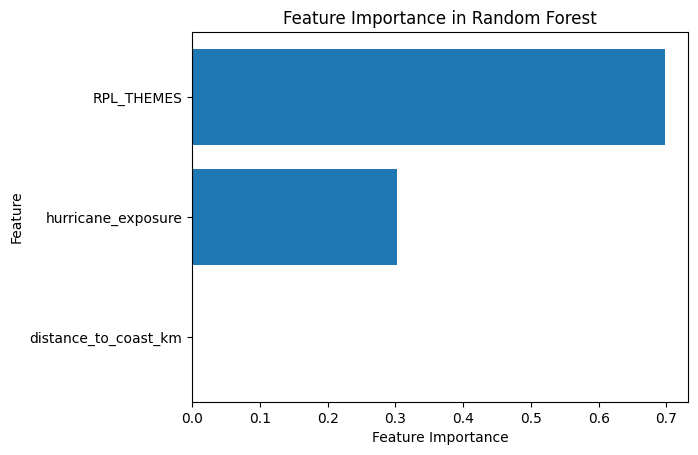

In [46]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns

# Plot
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.show()


In [47]:
# Save the model
joblib.dump(best_model, 'risk_prediction_model_best.pkl')

['risk_prediction_model_best.pkl']